In [1]:
# A few resources which has helped me understand the topic better:
# - https://www.youtube.com/watch?v=ZIvhuC0srXs
# - https://jonathan-hui.medium.com/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09
# - https://www.youtube.com/watch?v=OljTVUVzPpM&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=2

In [2]:
# importing libraries
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [3]:
# path where my resources are in local
path = "D:/Datasets/GANS"
os.chdir(path)

In [4]:
# you can play around with this to add more complex transformations.
# the dataset is very small so I have added a few transformation to increase the count.
# the transformations are pretty self explanatory
# if you are going to use an external dataset, then feel free to uncomment the below transformations
transform = transforms.Compose([
    #transforms.Resize(28),
    #transforms.Grayscale(1),
    transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.5)
])

In [5]:
# hyperparameters
device = "cpu" # i dont have a gpu.
lr = 3e-4 
notebook = False

In [17]:
# you can find the dataset i have used in the below link:
# https://www.kaggle.com/cactus3/basicshapes

# uncomment the below line if you are using a dataset from local, and provide necessary folder location.
# dataset = datasets.ImageFolder("Shapes/training_set", transform = transform)
batch_size = 32
dataset = datasets.MNIST(root="SimpleGansMNIST/", transform = transform, download = True)
loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [18]:
# lets see if our data is properly loaded
def plot_images(images):
    imgs = torchvision.utils.make_grid(images)
    npimgs = imgs.numpy()
    plt.figure(figsize = (8, 8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

torch.Size([32, 1, 28, 28]) torch.Size([32])


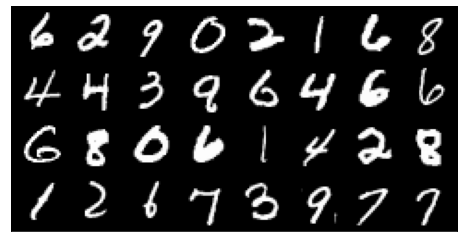

In [19]:
examples_data, examples_labels = next(iter(loader))
print(examples_data.shape, examples_labels.shape)

if notebook == True:
    plot_images(examples_data)

In [20]:
# Z_dim is the input vector of 100 dim to the generator
# Z_dim vector will be sampled from gaussian dstribution with 0 mean and 1 std
Z_dim = 100

# H_dim is the no of hidden nodes in the hidden layer
H_dim = 256

# X_dim is the flattened input vector to the neural network
X_dim = examples_data.view(examples_data.shape[0], -1).shape[-1]

print(Z_dim, H_dim, X_dim)

100 256 784


In [21]:
# Generator Model
# 1 hidden layer sequential model
class Generator(nn.Module):
    def __init__(self, generator_input_dim, output_image_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(generator_input_dim, H_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(H_dim, output_image_dim),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.model(x)

In [22]:
# No error, the implementation for generator looks good
G = Generator(Z_dim, X_dim)

In [23]:
# Discriminator model
# 1 hidden layer sequential model
class Discriminator(nn.Module):
    def __init__(self, input_image_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_image_dim, H_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(H_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [24]:
# No error, the implementation for discriminator looks good
D = Discriminator(X_dim)

In [25]:
G_opt = optim.Adam(G.parameters(), lr = lr)
D_opt = optim.Adam(D.parameters(), lr = lr)

# summary writers
writer_fake = SummaryWriter("TensorboardFiles/simpleGans/runs/fake")
writer_real = SummaryWriter("TensorboardFiles/simpleGans/runs/real")
steps = 0  # global steps

Epoch : 1,   Gen_loss : 4.277582804955693,   Disc_loss : 1.243619375160459
torch.Size([32, 1, 28, 28]) torch.Size([32, 1, 28, 28])


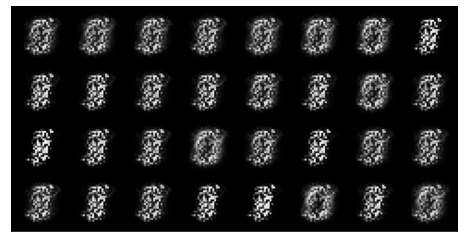

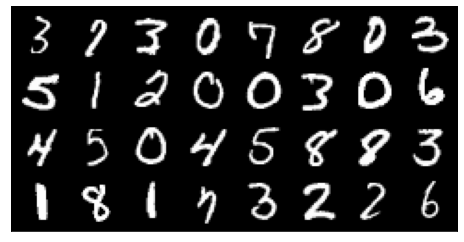

In [26]:
# training loop
n_epochs = 2
start = datetime.now()
for epoch in range(n_epochs):
    # setting initial loss values before every epoch
    G_loss_run = 0.0
    D_loss_run = 0.0
    
    for batch_idx, data in enumerate(loader):
        Real, _ = data
        batch_size = Real.shape[0]
        # reshaping the data into (batch_size, 784) matrix
        Real = Real.view(Real.shape[0], -1).to(device)
        
        # In discriminator we are trying to train it to better differentiate between real and false images
        # forward propagation for discriminator
        # true labels to match with real images during loss calculation
        one_labels = torch.ones(batch_size, 1)
        # false labels to match with fake images during loss calculation
        zero_labels = torch.zeros(batch_size, 1)
        
        # generating noise, which is input for generator
        noise = torch.randn(batch_size, Z_dim).to(device)
        
        # discriminator returns a value in between 0 and 1,
        # the returned value is compared against the true/false labels
        Disc_real = D(Real) # shape : (batch_size, (0 to 1))
        Disc_fake = D(G(noise)) # shape : (batch_size, (0 to 1))
        
        # crossentropy loss for real images
        Disc_real_loss = F.binary_cross_entropy(Disc_real, one_labels)
        # crossentropy loss for fake images
        Disc_fake_loss = F.binary_cross_entropy(Disc_fake, zero_labels)
        # total loss for discriminator
        Disc_loss = Disc_real_loss + Disc_fake_loss
        
        # backpropagation
        D_opt.zero_grad()
        Disc_loss.backward()
        D_opt.step()
        
        # forward propagation for generator
        # First, we use some noise to generate a random image.
        # the image is then fed to discriminator, so that it provides a value between 0 and 1.
        # because we are training discriminator before the generator so the discrimitor will always be one step ahead.
        # this advantage of discriminator helps discriminator give better probability value for the fake image.
        # the returned value is then used to figure out how well the generator has produced the fake image
        # so the generator will use a crossentropy loss to figure out what is the difference between the labels for fake image and actal images
        
        # noise, input to generator
        noise = torch.randn(batch_size, Z_dim).to(device)
        Disc_fake = D(G(noise))
        Gen_loss = F.binary_cross_entropy(Disc_fake, one_labels)
        
        # backpropagration
        G_opt.zero_grad()
        Gen_loss.backward()
        G_opt.step()
        
        # we are adding overall loss for discriminator and generator for all the iterations in an epoch
        G_loss_run += Gen_loss.item()
        D_loss_run += Disc_loss.item()
    
    if epoch % 2 == 0:
        print("Epoch : {},   Gen_loss : {},   Disc_loss : {}".format(epoch+1, G_loss_run/batch_idx+1, D_loss_run/batch_idx+1))
        
        # we dont want to compute gradient for this step, therefore .detach()
        sample_fake = G(noise).detach()
        sample_fake = sample_fake.view(sample_fake.shape[0], 1, 28, 28)
        sample_real = data[0]
        
        # making grids for tensorboard
        img_grid_fake = torchvision.utils.make_grid(sample_fake, normalize = True)
        img_grid_real = torchvision.utils.make_grid(sample_real, normalize = True)
        
        writer_fake.add_image(
            "MNIST Fake Images", img_grid_fake, global_step = step
        )
        
        writer_real.add_image(
            "MNIST Real Images", img_grid_real, global_step = step
        )
        
        step += 1
        
        if notebook == True:
            #print(sample_fake.shape, sample_real.shape)
            plot_images(sample_fake)
            plot_images(sample_real)
        